In [1]:
import keras
reconstructed_model = keras.models.load_model('/content/drive/My Drive/fold1_resnet34_1000.h5')

In [36]:
# !unzip drive/My\ Drive/Test_1000.zip
!unzip drive/My\ Drive/FOLD1_1000.zip

Streaming output truncated to the last 5000 lines.
  inflating: FOLD1/Validation/Epithelioid/TCGA-TS-A7OY-01Z-00-DX1.55585B4A-A419-42EF-80CF-ADD1A51854F1.svs/70880-55818.jpg  
  inflating: FOLD1/Validation/Epithelioid/TCGA-TS-A7OY-01Z-00-DX1.55585B4A-A419-42EF-80CF-ADD1A51854F1.svs/63792-46958.jpg  
  inflating: FOLD1/Validation/Epithelioid/TCGA-TS-A7OY-01Z-00-DX1.55585B4A-A419-42EF-80CF-ADD1A51854F1.svs/42528-27466.jpg  
  inflating: FOLD1/Validation/Epithelioid/TCGA-TS-A7OY-01Z-00-DX1.55585B4A-A419-42EF-80CF-ADD1A51854F1.svs/22150-09746.jpg  
  inflating: FOLD1/Validation/Epithelioid/TCGA-TS-A7OY-01Z-00-DX1.55585B4A-A419-42EF-80CF-ADD1A51854F1.svs/36326-20378.jpg  
  inflating: FOLD1/Validation/Epithelioid/TCGA-TS-A7OY-01Z-00-DX1.55585B4A-A419-42EF-80CF-ADD1A51854F1.svs/70880-40756.jpg  
  inflating: FOLD1/Validation/Epithelioid/TCGA-TS-A7OY-01Z-00-DX1.55585B4A-A419-42EF-80CF-ADD1A51854F1.svs/48730-49616.jpg  
  inflating: FOLD1/Validation/Epithelioid/TCGA-TS-A7OY-01Z-00-DX1.55585B4A

In [10]:
#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    y /= 255
    y_pred = reconstructed_model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list
    

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return

**Evaluation on test data for classification matrix**

In [19]:
from keras.preprocessing import image
import os
import glob
import pandas as pd
from fnmatch import fnmatch
import numpy as np


file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"

AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk("Test_1000"): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method


[Text(0, 0.5, 'Epithelioid'), Text(0, 1.5, 'Nonepithelioid')]

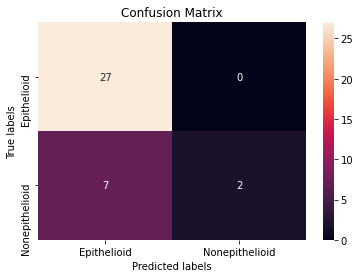

In [34]:
from sklearn import metrics
import matplotlib.pyplot as plt
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
conf_matrix = metrics.confusion_matrix(y_test_labels, AVG_LIST_PREDICTIONS)

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annoate = True is used to annotate the values

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Epithelioid', 'Nonepithelioid'])
ax.yaxis.set_ticklabels(['Epithelioid', 'Nonepithelioid'])

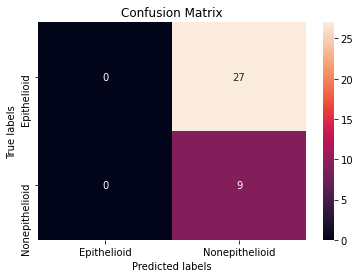

In [31]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt   

MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
confusi_matrix = metrics.confusion_matrix(y_test_labels, MAX_LIST_PREDICTIONS)
ax= plt.subplot()
sns.heatmap(confusi_matrix, annot=True, ax = ax); #annoate = True is used to annotate the values

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Epithelioid', 'Nonepithelioid'])
ax.yaxis.set_ticklabels(['Epithelioid', 'Nonepithelioid'])

In [39]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation using aggregation method")
for path, subdirs, files in os.walk("FOLD1/Validation"): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
            y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
            y_val_labels.append(1.0) 
        

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))

Prediction on validation using aggregation method


[Text(0, 0.5, 'Epithelioid'), Text(0, 1.5, 'Nonepithelioid')]

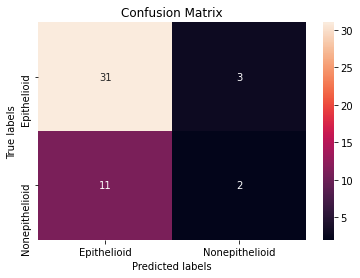

In [40]:
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
conf_matrix = metrics.confusion_matrix(y_val_labels, AVG_LIST_PREDICTIONS_VAL)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annoate = True is used to annotate the values

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Epithelioid', 'Nonepithelioid'])
ax.yaxis.set_ticklabels(['Epithelioid', 'Nonepithelioid'])

[Text(0, 0.5, 'Epithelioid'), Text(0, 1.5, 'Nonepithelioid')]

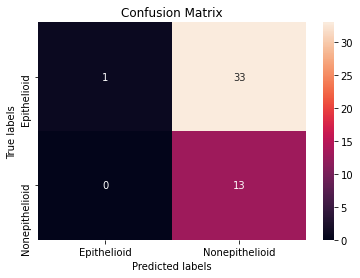

In [41]:
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
confusi_matrix = metrics.confusion_matrix(y_val_labels, MAX_LIST_PREDICTIONS_VAL)
ax= plt.subplot()
sns.heatmap(confusi_matrix, annot=True, ax = ax); #annoate = True is used to annotate the values

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Epithelioid', 'Nonepithelioid'])
ax.yaxis.set_ticklabels(['Epithelioid', 'Nonepithelioid'])

**Plotting the images to observe what kind of patches that model has misclassified**

In [ ]:
import numpy as np
from keras.preprocessing import image
import cv2
from google.colab.patches import cv2_imshow

def predict_singleimg(path):
    x = cv2.imread(path)
    cv2_imshow(x)#show image
    y = image.load_img(path)
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    y /= 255
    y_pred = reconstructed_model.predict(y)
    print(y_pred)

**Epithelioid Image**

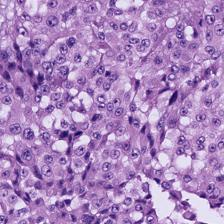

[[1.0000000e+00 6.6208764e-16]]


In [ ]:
predict_singleimg("/content/Test_1000/Epithelioid/TCGA-UD-AAC1-01Z-00-DX1.787A89D0-C918-43CF-9D1B-80DB1686BA21.svs/16326-81630.jpg")

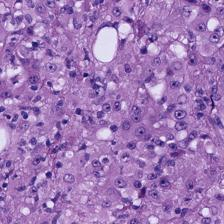

[[1.000000e+00 9.222648e-12]]


In [ ]:
predict_singleimg("/content/Test_1000/Epithelioid/TCGA-UD-AAC1-01Z-00-DX1.787A89D0-C918-43CF-9D1B-80DB1686BA21.svs/15419-70746.jpg")

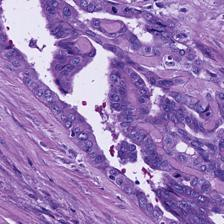

[[1.0000000e+00 1.7570952e-18]]


In [ ]:
predict_singleimg("/content/Test_1000/Epithelioid/TCGA-TS-A7OZ-01Z-00-DX1.F295DAAC-AD14-4B71-AFCE-4756D179811E.svs/81604-44350.jpg")

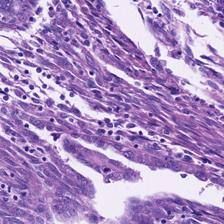

[[1.0000000e+00 4.3207918e-10]]


In [ ]:
predict_singleimg("Test_1000/Epithelioid/TCGA-TS-A7OZ-01Z-00-DX1.F295DAAC-AD14-4B71-AFCE-4756D179811E.svs/52333-23949.jpg")

**Nonepithelioid**

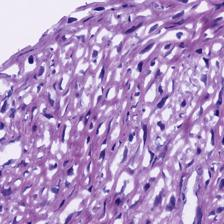

[[2.7071568e-08 1.0000000e+00]]


In [ ]:
predict_singleimg("Test_1000/Nonepithelioid/TCGA-3U-A98D-01A-01-TSA.0D34B5D8-691D-4BCF-A593-E5B0C0EECF53.svs/26580-03544.jpg")

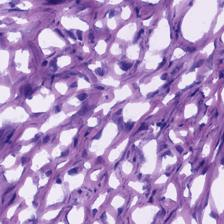

[[2.661304e-09 1.000000e+00]]


In [ ]:
predict_singleimg("/content/Test_1000/Nonepithelioid/TCGA-MQ-A4LM-01A-01-TS1.C57AECA8-F902-4E20-8EAF-015C8ECA2804.svs/65773-15317.jpg")

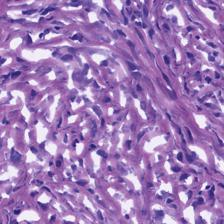

[[0.01714439 0.9828556 ]]


In [ ]:
predict_singleimg("/content/Test_1000/Nonepithelioid/TCGA-MQ-A4LM-01A-01-TS1.C57AECA8-F902-4E20-8EAF-015C8ECA2804.svs/34238-09010.jpg")

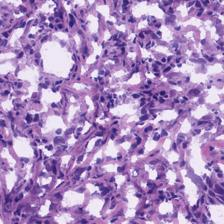

[[0.02029213 0.9797079 ]]


In [ ]:
predict_singleimg("/content/Test_1000/Nonepithelioid/TCGA-MQ-A4LM-01A-01-TS1.C57AECA8-F902-4E20-8EAF-015C8ECA2804.svs/87397-14416.jpg")

**Epithelioid classified as Nonepithelioid**

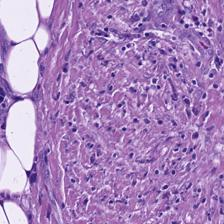

[[0.22626446 0.7737356 ]]


In [ ]:
predict_singleimg("Test_1000/Epithelioid/TCGA-TS-A7OZ-01Z-00-DX1.F295DAAC-AD14-4B71-AFCE-4756D179811E.svs/78056-40802.jpg")

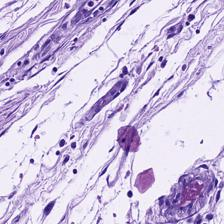

[[0.00999017 0.99000984]]


In [ ]:
predict_singleimg("Test_1000/Epithelioid/TCGA-TS-A7OZ-01Z-00-DX1.F295DAAC-AD14-4B71-AFCE-4756D179811E.svs/27497-29271.jpg")

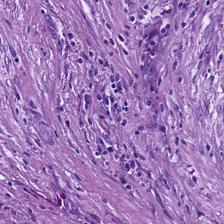

[[0.08042388 0.9195761 ]]


In [ ]:
predict_singleimg("Test_1000/Epithelioid/TCGA-TS-A7OZ-01Z-00-DX1.F295DAAC-AD14-4B71-AFCE-4756D179811E.svs/79830-43463.jpg")

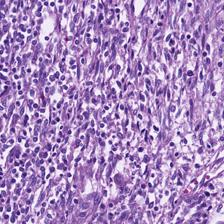

[[0.19052777 0.80947226]]


In [ ]:
predict_singleimg("/content/Test_1000/Epithelioid/TCGA-TS-A7OZ-01Z-00-DX1.F295DAAC-AD14-4B71-AFCE-4756D179811E.svs/120632-62977.jpg")

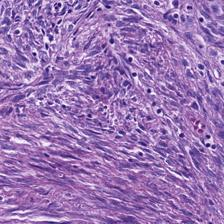

[[0.02983514 0.97016484]]


In [ ]:
predict_singleimg("/content/Test_1000/Epithelioid/TCGA-TS-A7OZ-01Z-00-DX1.F295DAAC-AD14-4B71-AFCE-4756D179811E.svs/23062-54107.jpg")

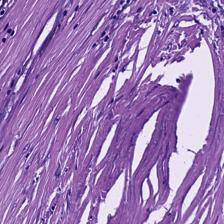

[[0.03144792 0.96855205]]


In [ ]:
predict_singleimg("/content/Test_1000/Epithelioid/TCGA-TS-A7OZ-01Z-00-DX1.F295DAAC-AD14-4B71-AFCE-4756D179811E.svs/35480-23949.jpg")

**Nonepithelioid Classified as Epithelioid**

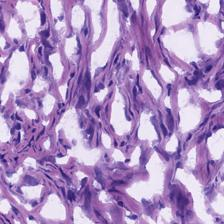

[[0.9700726  0.02992742]]


In [ ]:
predict_singleimg("/content/Test_1000/Nonepithelioid/TCGA-MQ-A4LM-01A-01-TS1.C57AECA8-F902-4E20-8EAF-015C8ECA2804.svs/77486-20723.jpg")

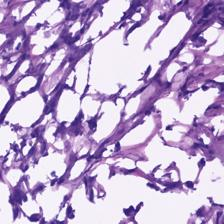

[[1.0000000e+00 4.1531298e-08]]


In [ ]:
predict_singleimg("/content/Test_1000/Nonepithelioid/TCGA-MQ-A4LM-01A-01-TS1.C57AECA8-F902-4E20-8EAF-015C8ECA2804.svs/60367-11713.jpg")

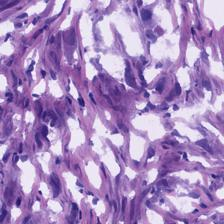

[[0.98564065 0.01435932]]


In [ ]:
predict_singleimg("/content/Test_1000/Nonepithelioid/TCGA-MQ-A4LM-01A-01-TS1.C57AECA8-F902-4E20-8EAF-015C8ECA2804.svs/81991-19822.jpg")

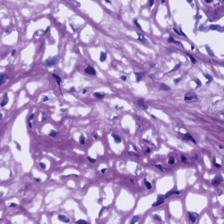

[[0.99132216 0.00867786]]


In [ ]:
predict_singleimg("Test_1000/Nonepithelioid/TCGA-3U-A98D-01A-01-TSA.0D34B5D8-691D-4BCF-A593-E5B0C0EECF53.svs/68222-10632.jpg")